In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
url = "https://raw.githubusercontent.com/nahwan25/Machine-Learning/refs/heads/main/Regression2/diamonds.csv"
data = pd.read_csv(url, sep=',', index_col=0) #Ganti dataset sesuai dengan yang saya beri
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
data.shape

(53940, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [5]:
data.drop_duplicates(inplace=True)

In [6]:
for col in data.select_dtypes(include='object').columns:
    print(f"Kolom: {col}")
    print(data[col].unique(), "\n")

Kolom: cut
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair'] 

Kolom: color
['E' 'I' 'J' 'H' 'F' 'G' 'D'] 

Kolom: clarity
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF'] 



In [7]:
# Mapping untuk konversi ordinal ke numerik
cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

# Mengubah kategori menjadi numerik
data['cut'] = data['cut'].map(cut_mapping)
data['color'] = data['color'].map(color_mapping)
data['clarity'] = data['clarity'].map(clarity_mapping)

# Menampilkan hasil
print(data.head())

   carat  cut  color  clarity  depth  table  price     x     y     z
1   0.23    5      6        2   61.5   55.0    326  3.95  3.98  2.43
2   0.21    4      6        3   59.8   61.0    326  3.89  3.84  2.31
3   0.23    2      6        5   56.9   65.0    327  4.05  4.07  2.31
4   0.29    4      2        4   62.4   58.0    334  4.20  4.23  2.63
5   0.31    2      1        2   63.3   58.0    335  4.34  4.35  2.75


In [8]:
def iqr_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    data[col] = data[col].mask(data[col] < lower_bound, Q1)
    data[col] = data[col].mask(data[col] > upper_bound, Q3)
    return data

# Pilih kolom numerik
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Terapkan fungsi iqr_outliers pada kolom numerik
for col in numeric_cols:
    data = iqr_outliers(data, col)

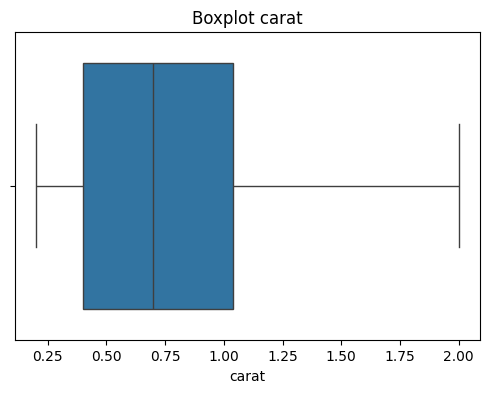

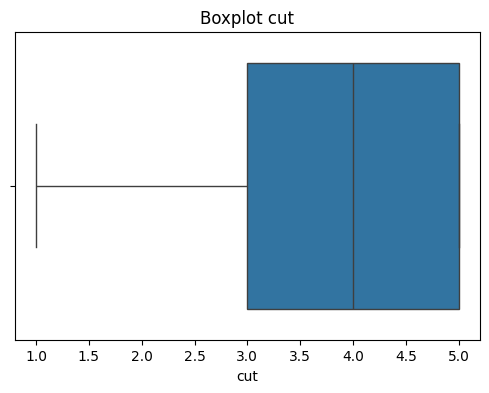

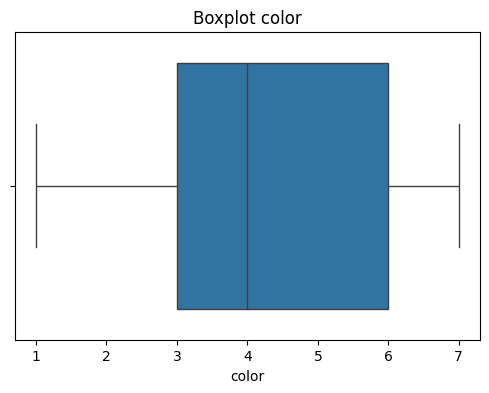

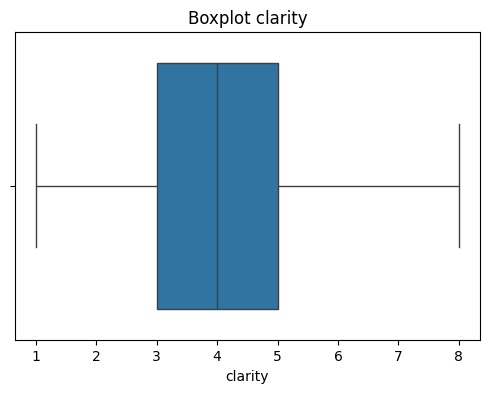

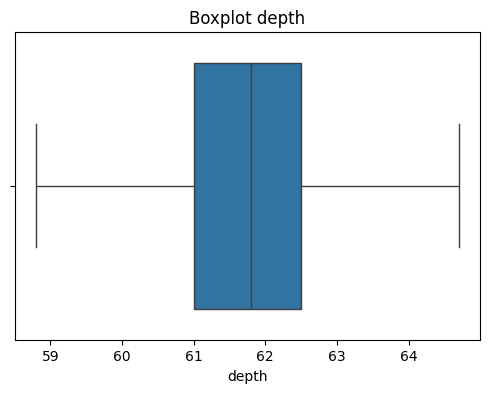

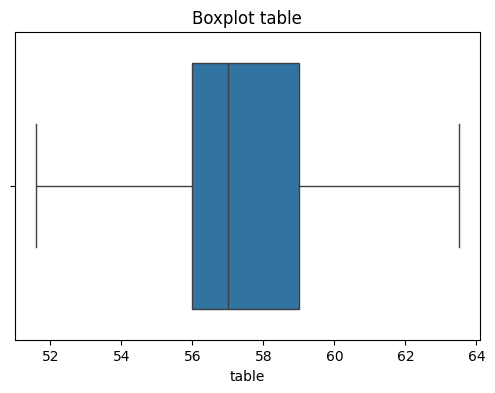

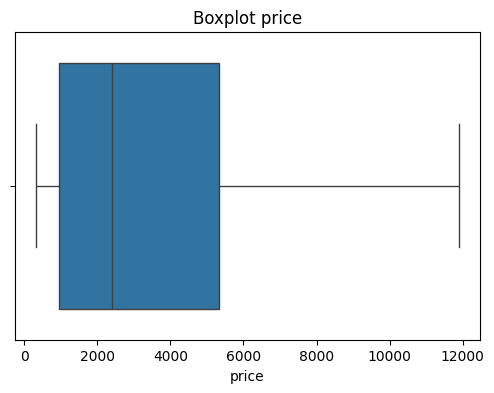

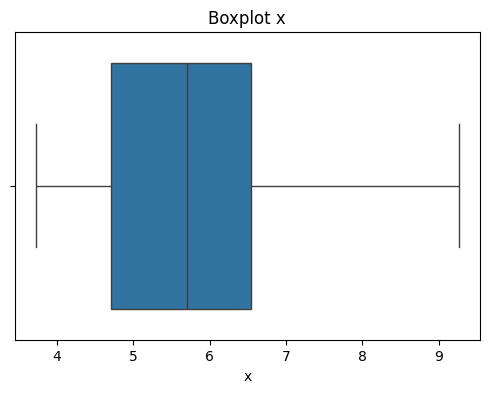

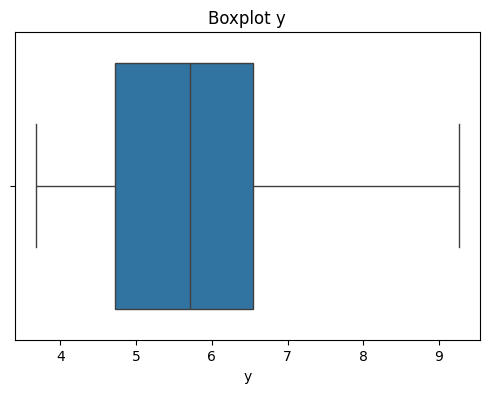

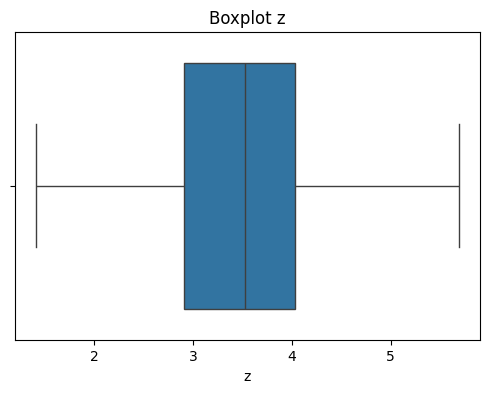

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih kolom numerik
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplot untuk setiap kolom numerik
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot {col}')
    plt.show()

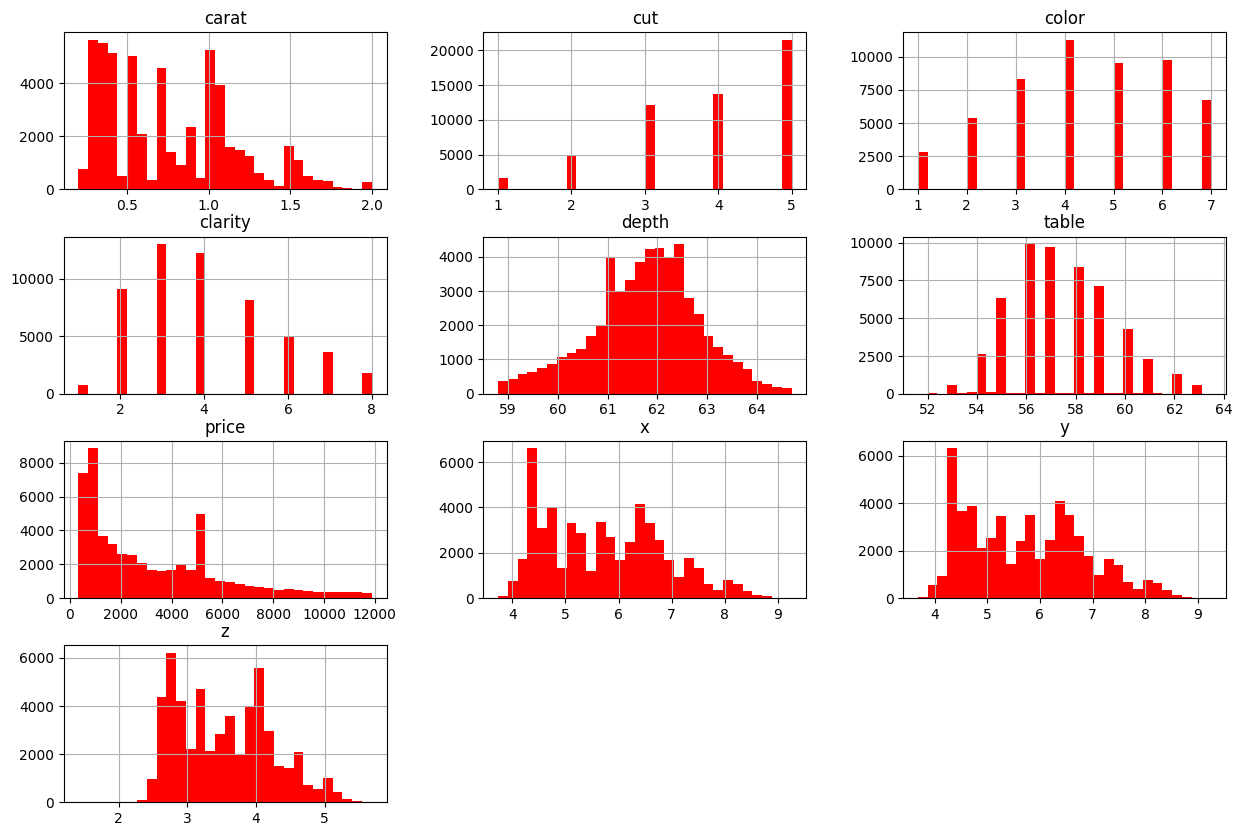

In [10]:
# visualisasi menggunakan histogram untuk melihat distribusi data
data.hist(figsize=(15, 10), bins=30,color='red');

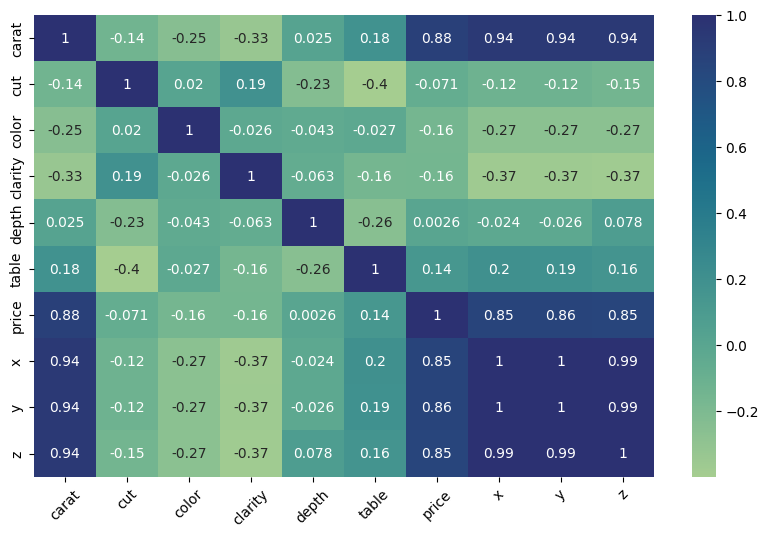

In [11]:
# visualisasi menggunakan heatmap untuk melihat korelasi antar variabel
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='crest')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Menghapus kolom redundant
data.drop(columns=['x', 'z', 'depth'], inplace=True)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Daftar kolom yang tidak ingin di-scale
exclude_cols = ['cut', 'color', 'clarity']

# Pilih kolom numerik selain 'cut', 'color', dan 'clarity'
num_cols = [col for col in data.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Transformasi hanya untuk kolom numerik yang tidak dikecualikan
data[num_cols] = scaler.fit_transform(data[num_cols])

# Menampilkan hasil
print(data.head())

      carat  cut  color  clarity     table     price         y
1  0.016667    5      6        2  0.285714  0.000000  0.053763
2  0.005556    4      6        3  0.789916  0.000000  0.028674
3  0.016667    2      6        5  0.621849  0.000086  0.069892
4  0.050000    4      2        4  0.537815  0.000692  0.098566
5  0.061111    2      1        2  0.537815  0.000778  0.120072


In [14]:
# Assigning the featurs as X and trarget as y
X= data.drop(["price"],axis =1)
y= data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

In [15]:
# Daftar model yang akan diuji
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Menyimpan hasil evaluasi
results = []

# Iterasi melalui setiap model
for name, model in models.items():
    # Latih model
    model.fit(X_train, y_train)
    # Prediksi
    y_pred = model.predict(X_test)
    # Hitung metrik
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # Simpan hasil
    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse
    })

# Konversi hasil ke DataFrame untuk tampilan tabel
results_df = pd.DataFrame(results)

# Tampilkan tabel hasil
print(results_df)

               Model       MAE       MSE
0  Linear Regression  0.062716  0.009960
1   Ridge Regression  0.062731  0.009960
2   Lasso Regression  0.193132  0.054368
3      Decision Tree  0.031015  0.005798
4      Random Forest  0.025298  0.003352
5  Gradient Boosting  0.036512  0.004945
